In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from gensim.models import Word2Vec

In [12]:
#Đọc dữ liệu
df = pd.read_excel("Films_Data.xlsx")
df.head(5)

,Title,Year,Duration,MPAA,Genres,IMDb_Rating,Director,Stars,Plot_Summary,Image_link
0,Gladiator II,2024,2h 28min,T18,"Action, Adventure, Drama",6.9,Ridley Scott,"Paul Mescal, Denzel Washington, Pedro Pascal",After his home is conquered by the tyrannical ...,https://m.media-amazon.com/images/M/MV5BM2VjZG...
1,Moana 2,2024,1h 40min,P,"Animation, Adventure, Comedy",7.1,David G. Derrick Jr.,"Auli'i Cravalho, Dwayne Johnson, Hualalai Chung",After receiving an unexpected call from her wa...,https://m.media-amazon.com/images/M/MV5BZDUxNT...
2,Gladiator,2000,2h 35min,R,"Action, Adventure, Drama",8.5,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen",A former Roman General sets out to exact venge...,https://m.media-amazon.com/images/M/MV5BYWQ4Ym...
3,The Substance,2024,2h 21min,R,"Drama, Horror",7.4,Coralie Fargeat,"Demi Moore, Margaret Qualley, Dennis Quaid",A fading celebrity takes a black-market drug: ...,https://m.media-amazon.com/images/M/MV5BMTc2M2...
4,Dear Santa,2024,1h 47min,PG-13,"Comedy, Fantasy, Horror",5.3,Bobby Farrelly,"Jack Black, Robert Timothy Smith, Keegan-Micha...",When a young boy mails his Christmas wish list...,https://m.media-amazon.com/images/M/MV5BMDNjMz...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455 entries, 0 to 5454
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         5455 non-null   object 
 1   Year          5455 non-null   int64  
 2   Duration      5455 non-null   object 
 3   MPAA          5353 non-null   object 
 4   Genres        5455 non-null   object 
 5   IMDb_Rating   5455 non-null   float64
 6   Director      5432 non-null   object 
 7   Stars         5433 non-null   object 
 8   Plot_Summary  5432 non-null   object 
 9   Image_link    5455 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 426.3+ KB


In [14]:
def prepare_combined_content(df):
    text_columns = ['Title', 'Genres', 'Director', 'Stars', 'Plot_Summary']
    for col in text_columns:
        df[col] = df[col].fillna('').astype(str)
    # Gộp các cột thành một chuỗi duy nhất, kèm theo trọng số IMDb rating
    df['combined_content'] = (
        df['Title'] + ' ' +
        df['Genres'] + ' ' +
        df['Director'] + ' ' +
        df['Stars'] + ' ' +
        df['Plot_Summary']
    )
    return df

def calculate_movie_similarity(df):
    # Chuẩn bị dữ liệu
    df = prepare_combined_content(df)
    
    # Sử dụng CountVectorizer để chuyển đổi văn bản thành vector
    vectorizer = CountVectorizer(stop_words='english')
    content_matrix = vectorizer.fit_transform(df['combined_content'])
    
    # Nhân vector với trọng số IMDb rating để điều chỉnh độ tương đồng
    imdb_weights = df['IMDb_Rating'].values.reshape(-1, 1)
    weighted_matrix = content_matrix.multiply(imdb_weights)
    
    # Tính cosine similarity
    similarity_matrix = cosine_similarity(weighted_matrix)
    
    return similarity_matrix, df, vectorizer

def calculate_movie_score(user_input, df):
    # Tính toán ma trận độ tương đồng
    similarity_matrix, processed_df, vectorizer = calculate_movie_similarity(df)
    
    # Lọc các phim dựa trên input của người dùng
    filtered_df = processed_df.copy()
    
    # Áp dụng các bộ lọc nếu có thông tin
    if user_input.get('Genres'):
        filtered_df = filtered_df[filtered_df['Genres'].str.contains(user_input['Genres'], case=False, na=False)]
    if user_input.get('Director'):
        filtered_df = filtered_df[filtered_df['Director'].str.contains(user_input['Director'], case=False, na=False)]
    if user_input.get('Stars'):
        filtered_df = filtered_df[filtered_df['Stars'].str.contains(user_input['Stars'], case=False, na=False)]
    
    # Nếu có tên phim cụ thể
    if user_input.get('Title'):
        # Tìm index của các phim có tên gần giống
        movie_indices = processed_df[
            processed_df['Title'].str.contains(user_input['Title'], case=False, na=False)
        ].index.tolist()
        
        if movie_indices:
            # Nếu có nhiều phim, lấy phim đầu tiên
            movie_idx = movie_indices[0]
            
            # Lấy điểm tương đồng của phim này với các phim khác
            similarity_scores = similarity_matrix[movie_idx]
            
            # Gán điểm cho các phim trong filtered_df
            filtered_df['score'] = 0.0  # Khởi tạo cột score với giá trị 0
            for orig_idx, score in zip(processed_df.index, similarity_scores):
                # Loại trừ chính phim đang tìm
                if orig_idx in filtered_df.index and orig_idx != movie_idx:
                    filtered_df.loc[orig_idx, 'score'] = score
            
            # Sắp xếp và lấy top 5 phim
            filtered_df = filtered_df[filtered_df.index != movie_idx]  # Loại bỏ phim gốc
            filtered_df = filtered_df.sort_values(by='score', ascending=False).head(5)
    
    # Nếu không có tên phim cụ thể
    else:
        # Tạo vector đại diện cho input
        input_sentence = ' '.join([
            user_input.get('Genres', ''),
            user_input.get('Director', ''),
            user_input.get('Stars', '')
        ])
        
        # Chuyển đổi input thành vector
        input_vector = vectorizer.transform([input_sentence])
        
        # Tính độ tương đồng của input vector với các phim
        input_similarity = cosine_similarity(input_vector, vectorizer.transform(filtered_df['combined_content']))[0]
        
        # Gán điểm cho các phim trong filtered_df
        filtered_df['score'] = input_similarity
        
        # Sắp xếp và lấy top 5 phim
        filtered_df = filtered_df.sort_values(by='score', ascending=False).head(5)
    
    return filtered_df

def display_recommended_movies(user_input, df):
    recommended_movies = calculate_movie_score(user_input, df)
    
    # Thiết lập phông chữ đẹp cho tiêu đề
    font = {'family': 'sans-serif', 'weight': 'bold', 'size': 14}
    
    # Tạo một figure để vẽ hình ảnh
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))  # 5 hình ảnh trên 1 hàng
    fig.subplots_adjust(wspace=0.2)
    
    for i in range(len(recommended_movies)):
        movie = recommended_movies.iloc[i]
        
        # Tải hình ảnh từ URL
        url = movie['Image_link']
        try:
            im = Image.open(requests.get(url, stream=True).raw)
        except:
            axs[i].axis('off')  # Nếu không tải được, để ô trống
            axs[i].set_title(f"{movie['Title']}\nImage not available", fontdict=font, color='gray')
            continue
        
        # Hiển thị hình ảnh
        axs[i].imshow(im)
        axs[i].axis('off')  # Tắt trục
        
        # Thiết lập tiêu đề với rating
        axs[i].set_title(f"{movie['Title']}\nRating: {round(movie['IMDb_Rating'], 1)}", 
                         fontdict=font, color='red', y=-0.18)
    
    # Hiển thị tất cả hình ảnh
    plt.show()



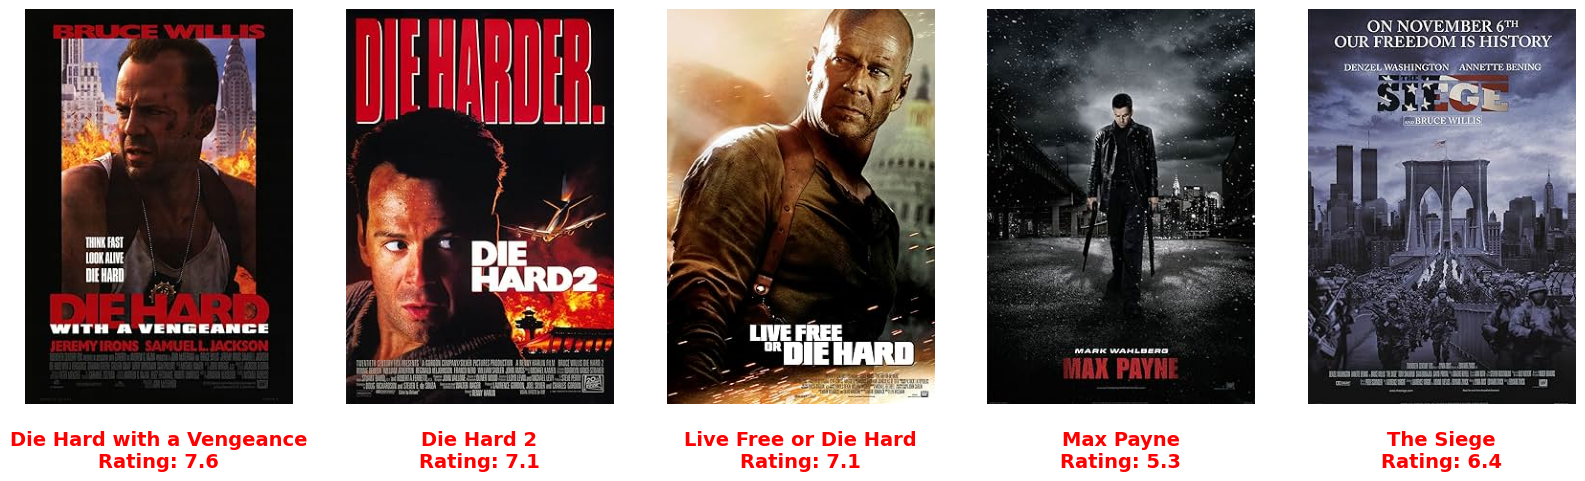

In [15]:
user_input = {
    'Title': "Die Hard",  # Tìm phim
    'Genres': "",  # Tìm thể loại 
    'Director': "",  # Tìm đạo diễn
    'Stars': ""  # Tìm diễn viên
}
display_recommended_movies(user_input, df)